Project Artificial Intelligence — Klasifikasi Prediksi Customer Churn (Telekomunikasi)

Setup & import

In [22]:
# Cell 1: Import
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt


Load data

In [23]:
# Cell 5: Load dataset
# Biasanya nama file: WA_Fn-UseC_-Telco-Customer-Churn.csv
path = "dataaset/WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = pd.read_csv(path)
df.head()

# Cell 6: Cek info dasar
print(df.shape)
df.info()
df.isna().sum().sort_values(ascending=False).head(10)

(7043, 21)
<class 'pandas.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   str    
 1   gender            7043 non-null   str    
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   str    
 4   Dependents        7043 non-null   str    
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   str    
 7   MultipleLines     7043 non-null   str    
 8   InternetService   7043 non-null   str    
 9   OnlineSecurity    7043 non-null   str    
 10  OnlineBackup      7043 non-null   str    
 11  DeviceProtection  7043 non-null   str    
 12  TechSupport       7043 non-null   str    
 13  StreamingTV       7043 non-null   str    
 14  StreamingMovies   7043 non-null   str    
 15  Contract          7043 non-null   str    
 16  PaperlessBilling  7043 non-null   str    


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

Cleaning ringan

In [24]:
# Cell 7: Cleaning TotalCharges
# TotalCharges kadang kebaca sebagai string karena ada spasi kosong.
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Drop customerID (ID doang)
df = df.drop(columns=["customerID"])

df.isna().sum().sort_values(ascending=False).head(10)

TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
dtype: int64

Pisah X/y dan train-test split

In [25]:
# Cell 8: Split
X = df.drop(columns=["Churn"])
y = df["Churn"].map({"Yes": 1, "No": 0})  # target biner

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((5634, 19), (1409, 19))

Preprocessing (numerik + kategori) dengan Pipeline

In [26]:
# Cell 9: Preprocess pipeline
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

num_cols, cat_cols[:10], len(cat_cols)


/tmp/ipykernel_40656/1719027656.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include=["object"]).columns.tolist()


(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'],
 ['gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport'],
 15)

Model 1 (baseline): Logistic Regression

In [27]:
# Cell 10: Logistic Regression baseline
logreg_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=2000))
])

logreg_model.fit(X_train, y_train)

pred = logreg_model.predict(X_test)
proba = logreg_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred))
print("ROC-AUC :", roc_auc_score(y_test, proba))
print("\nClassification report:\n", classification_report(y_test, pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred))


Accuracy: 0.8055358410220014
ROC-AUC : 0.8418610659019866

Classification report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409


Confusion matrix:
 [[926 109]
 [165 209]]


Model 2 (lebih kuat): Random Forest

In [28]:
# Cell 11: Random Forest
rf_model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)

pred_rf = rf_model.predict(X_test)
proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, pred_rf))
print("ROC-AUC :", roc_auc_score(y_test, proba_rf))
print("\nClassification report:\n", classification_report(y_test, pred_rf))
print("\nConfusion matrix:\n", confusion_matrix(y_test, pred_rf))


Accuracy: 0.7814052519517388
ROC-AUC : 0.8216732542819498

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1035
           1       0.62      0.47      0.53       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409


Confusion matrix:
 [[927 108]
 [200 174]]


Plot ROC Curve

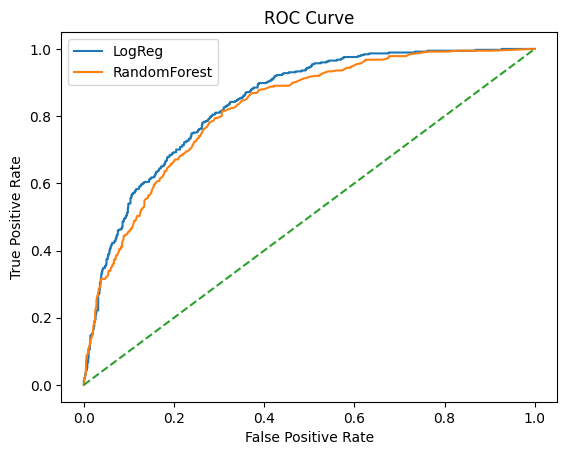

In [29]:
# Cell 12: ROC curve
fpr1, tpr1, _ = roc_curve(y_test, proba)
fpr2, tpr2, _ = roc_curve(y_test, proba_rf)

plt.figure()
plt.plot(fpr1, tpr1, label="LogReg")
plt.plot(fpr2, tpr2, label="RandomForest")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


Simpan model

In [30]:
# Cell 13: Save model
import joblib
joblib.dump(rf_model, "model_churn_rf.joblib")
print("Saved: model_churn_rf.joblib")

Saved: model_churn_rf.joblib
